# Portland Trail Blazers - RFM Clustering : Package Buyers
* StelllarAlgo Data Science
* Ryan Kazmerik
* Jul 15, 2022

## Hypothesis

The NBA has provided StellarAlgo with a dataset containing ~400,000 fans who are engaging with the Portland Trail Blazers team through various channels, but are unknown to the team as they have not yet purchased a ticket.

***We estimate that by calculating RFM (recency, frequency, monetary) metrics for known PTB fans, we can approximate the Potential Gross Revenue of the unknown fans.***

This experiment will start with some exploratory data analysis, then calculate and cluster the known fans based on the RFM metrics. Then we'll segment the known fans into three groups and calculate the **Total Gross Revenue** of each group.

The same segmentation is applied to the unknown fans provided by the NBA, allowing us to approximate the **Potential Gross Revenue** for each segment.

In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd

#from pandas_profiling import ProfileReport
from sklearn.cluster import KMeans
from pycaret.clustering import *

pd.set_option('display.float_format', lambda x: '%.2f' % x)

#plt.style.use('dark_background') 
plt.style.use('default') 


## Data Wrangling

For our experiment, we need two datasets:
1. Fans who have bought tickets to a Trail Blazers game. We can get this from our Trail Blazers StellarAlgo tables.
2. Fans who have engaged with the Trail Blazers via streaming, or gaming data. This we can get from our dataset provided by the NBA.

### PTB Ticketing Dataset

In [2]:
"""
    data/ptb_cohort_purchase.csv contains data from the following query:

    SELECT p.dimcustomermasterid, p.purchasedate, p.ticketcount, p.revenue, p.isplanproduct, p.producttype, p.subproductname, p.seasonyear,
       c.dimcustomermasterid, c.country, c.stateprovince, c.zippostal 
    FROM "ptb_cohort_purchase"  p 
    INNER JOIN "ptb_dim_customer_master" c
    ON p.dimcustomermasterid = c.dimcustomermasterid
"""

df = pd.read_csv("./data/ptb_cohort_purchase.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1975722 entries, 0 to 1975721
Data columns (total 11 columns):
 #   Column               Dtype  
---  ------               -----  
 0   dimcustomermasterid  int64  
 1   purchasedate         object 
 2   ticketcount          int64  
 3   revenue              float64
 4   isplanproduct        bool   
 5   producttype          object 
 6   subproductname       object 
 7   seasonyear           int64  
 8   country              object 
 9   stateprovince        object 
 10  zippostal            object 
dtypes: bool(1), float64(1), int64(3), object(6)
memory usage: 152.6+ MB


In [3]:
df.head()

,dimcustomermasterid,purchasedate,ticketcount,revenue,isplanproduct,producttype,subproductname,seasonyear,country,stateprovince,zippostal
0,702748196,2017-02-06,2,68.00,True,Package,Full Season,2017,USA,OR,97123-4016
1,702748196,2017-02-06,2,68.00,True,Package,Full Season,2017,USA,OR,97123-4016
2,702748196,2017-02-06,2,68.00,True,Package,Full Season,2017,USA,OR,97123-4016
3,702748196,2017-02-06,2,302.40,True,Package,Full Season,2017,USA,OR,97123-4016
4,702748196,2017-02-06,2,68.00,True,Package,Full Season,2017,USA,OR,97123-4016


### NBA Engagement Dataset

In [4]:
"""
  data/ptb_nba_engagement.csv contains data from the following query:

  SELECT dimcustomermasterid, entity_source
  FROM "league-nba-poc"."tagged_customer_master";
"""

df2 = pd.read_csv("./data/ptb_nba_engagement.csv")
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1671077 entries, 0 to 1671076
Data columns (total 5 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   dimcustomermasterid  1671077 non-null  int64 
 1   country_value        1447104 non-null  object
 2   stateprovince_value  936378 non-null   object
 3   zippostal_value      1263889 non-null  object
 4   entity_source        402626 non-null   object
dtypes: int64(1), object(4)
memory usage: 63.7+ MB


## Data Preprocessing

For our analysis we will only consider **package buyers**, because we are interested in modelling the typical individual ticket buyer. Let's see how much data we have for package buyers and what sub-products are included:

In [5]:
df['isplanproduct'].value_counts()

True     1017544
False     958178
Name: isplanproduct, dtype: int64

Remove the rows where isplanproduct = False:

In [6]:
df = df[df['isplanproduct'] == True]
df.drop(columns=["isplanproduct"], inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017544 entries, 0 to 1975721
Data columns (total 10 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   dimcustomermasterid  1017544 non-null  int64  
 1   purchasedate         1017544 non-null  object 
 2   ticketcount          1017544 non-null  int64  
 3   revenue              1017544 non-null  float64
 4   producttype          1017544 non-null  object 
 5   subproductname       1017544 non-null  object 
 6   seasonyear           1017544 non-null  int64  
 7   country              1017438 non-null  object 
 8   stateprovince        1010237 non-null  object 
 9   zippostal            1015104 non-null  object 
dtypes: float64(1), int64(3), object(6)
memory usage: 85.4+ MB


Let's include data from 2018 to present in our analysis, so we'll remove data from seasons prior to 2018:

In [7]:
df = df[df["seasonyear"] >= 2018]
df.shape

(787570, 10)

We'll also have a look at the included product and subproduct types:

In [8]:
df["producttype"].value_counts()

Package    787570
Name: producttype, dtype: int64

In [9]:
df["subproductname"].value_counts()

Full Season              665342
Half Season               60193
Quarter Season            29543
Full Season Broker        19893
Mini Plan                 12101
Half Season Broker          366
Quarter Season Broker        72
Mini Plan Broker             60
Name: subproductname, dtype: int64

Let's remove the broker records so we are looking at actual customer behaviour:

In [10]:
df = df[df["subproductname"].isin(["Full Season","Half Season","Quarter Season","Mini Plan"])]
df.reset_index(drop=True, inplace=True)

df["subproductname"].value_counts()

Full Season       665342
Half Season        60193
Quarter Season     29543
Mini Plan          12101
Name: subproductname, dtype: int64

In [11]:
df.head()

,dimcustomermasterid,purchasedate,ticketcount,revenue,producttype,subproductname,seasonyear,country,stateprovince,zippostal
0,702748196,2018-02-26,2,75.20,Package,Full Season,2018,USA,OR,97123-4016
1,702748196,2018-02-26,1,168.00,Package,Full Season,2018,USA,OR,97123-4016
2,702748196,2018-02-26,2,75.20,Package,Full Season,2018,USA,OR,97123-4016
3,702748196,2018-02-26,2,336.00,Package,Full Season,2018,USA,OR,97123-4016
4,702748196,2018-02-26,2,75.20,Package,Full Season,2018,USA,OR,97123-4016


## Exploratory Data Analysis (EDA)

Let's have a closer look at the data and decide whether we need any data cleaning and data transformation for further analysis:

In [12]:
# generate a pandas profile report on the ptb dataset
#profile = ProfileReport(df, minimal=True)
#profile.to_file("./reports/pandas-profile-report-pb.html")

By reading the profiling report, we can see that the following actions should be taken to improve the dataset quality:
* Revenue is highly skewed

There are no major missing values so the data looks to be in good shape, we can deal with the revenue skew later on in this notebook.

In [14]:
df = df[df['revenue'] > 0]
df['revenue'].value_counts(bins=[0, 1000, 10000, 100000])

(-0.001, 1000.0]       198888
(1000.0, 10000.0]        4225
(10000.0, 100000.0]        17
Name: revenue, dtype: int64

### Data Types

Let's look at the data types in our dataframe to see if we need to convert any values to a different type

In [13]:
df.dtypes

dimcustomermasterid      int64
purchasedate            object
ticketcount              int64
revenue                float64
producttype             object
subproductname          object
seasonyear               int64
country                 object
stateprovince           object
zippostal               object
dtype: object

Purchase date should be a datetime not an object (string), all of the other inferred data types look correct:

In [14]:
df['purchasedate'] =  pd.to_datetime(df['purchasedate'], format='%Y-%m-%d')

Our cleaned up dataset is ready for the next step, calculating RFM metrics:

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 767179 entries, 0 to 767178
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   dimcustomermasterid  767179 non-null  int64         
 1   purchasedate         767179 non-null  datetime64[ns]
 2   ticketcount          767179 non-null  int64         
 3   revenue              767179 non-null  float64       
 4   producttype          767179 non-null  object        
 5   subproductname       767179 non-null  object        
 6   seasonyear           767179 non-null  int64         
 7   country              767078 non-null  object        
 8   stateprovince        761446 non-null  object        
 9   zippostal            765270 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(5)
memory usage: 58.5+ MB


In [16]:
df.head()

,dimcustomermasterid,purchasedate,ticketcount,revenue,producttype,subproductname,seasonyear,country,stateprovince,zippostal
0,702748196,2018-02-26,2,75.20,Package,Full Season,2018,USA,OR,97123-4016
1,702748196,2018-02-26,1,168.00,Package,Full Season,2018,USA,OR,97123-4016
2,702748196,2018-02-26,2,75.20,Package,Full Season,2018,USA,OR,97123-4016
3,702748196,2018-02-26,2,336.00,Package,Full Season,2018,USA,OR,97123-4016
4,702748196,2018-02-26,2,75.20,Package,Full Season,2018,USA,OR,97123-4016


## Calculating RFM Metrics

**RFM** stands for Recency - Frequency - Monetary Value. Theoretically we will have segments like below:

* Low Value: Customers who are less active than others, not very frequent buyer/visitor and generates low revenue.

* Mid Value: In the middle of everything. Often purchasing (but not as much as our High Values), fairly frequent and generates moderate revenue.

* High Value: The group we don’t want to lose. High Revenue, Frequency and low Inactivity.

Let's create a dataframe to hold basic information about each individual customer:

In [17]:
# create a generic user dataframe to keep dimcustomermasterid and new segmentation scores
df_customer = df[["dimcustomermasterid", "country", "stateprovince"]]
df_customer = df_customer.drop_duplicates(subset="dimcustomermasterid", keep="first")

df_customer.head()

,dimcustomermasterid,country,stateprovince
0,702748196,USA,OR
6,486156197,USA,OR
11,380867215,USA,OR
32,612705220,USA,OR
49,622305647,USA,OR


### Recency

To calculate recency, we need to find out most recent purchase date of each customer and see how many days they are inactive for. After having no. of inactive days for each customer, we will apply K-means* clustering to assign customers a recency score:

In [18]:
# get the max purchase date for each customer and create a dataframe with it
df_max_purchase = df.groupby('dimcustomermasterid')["purchasedate"].max().reset_index()
df_max_purchase.columns = ['dimcustomermasterid','maxpurchasedate']

# we take our observation point as the max invoice date in our dataset
df_max_purchase['recency'] = (df_max_purchase['maxpurchasedate'].max() - df_max_purchase['maxpurchasedate']).dt.days

#merge this dataframe to our new user dataframe
df_customer = pd.merge(df_customer, df_max_purchase[['dimcustomermasterid','recency']], on='dimcustomermasterid')

df_customer.head()

,dimcustomermasterid,country,stateprovince,recency
0,702748196,USA,OR,554
1,486156197,USA,OR,91
2,380867215,USA,OR,553
3,612705220,USA,OR,163
4,622305647,USA,OR,309


Let's have a look at the standard statistics for the recency metric, specifically the mean, min and max values help us to understand the range of values in this metric:

In [19]:
df_customer["recency"].describe()

count   10208.00
mean      614.50
std       514.82
min         0.00
25%       163.00
50%       360.00
75%      1116.00
max      1613.00
Name: recency, dtype: float64

Let's have a look at the distribution to see if there are any outlier datapoints affecting the range of values:

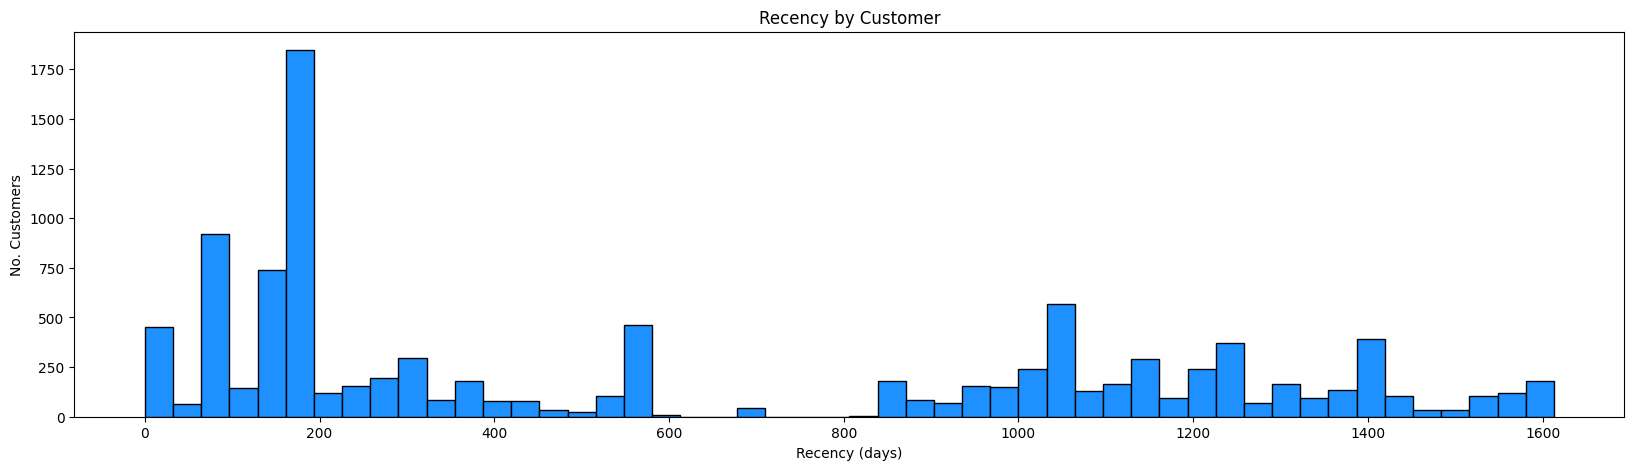

In [50]:
recency_fig = plt.figure(figsize=(20, 5))
plt.hist(df_customer["recency"], bins=50, color="dodgerblue", edgecolor="black")
plt.title("Recency by Customer")
plt.ylabel("No. Customers")
plt.xlabel("Recency (days)")

plt.show()

We can observe a large gap in purchasing behaviour between ~800 - 600 days ago, which aligns with when COVID-19 was declared a global pandemic. There's not much we can do to fill in that gap, so we'll leave the data as is.

### Clustering Recency

We are going to apply K-means clustering to assign a recency score. We will use the elbow method to determine how many clusters we need:

In [38]:
df_recency = df_customer[['recency']]

setup(
    df_recency, 
    silent= True,
    verbose= False
);

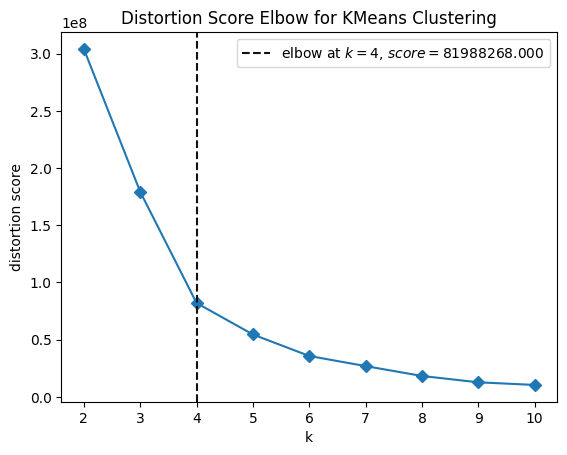

In [41]:
kmeans = create_model('kmeans')
plot_model(kmeans, plot = 'elbow')

Here it looks like 3 is the optimal number of clusters as we don't get any increase in learning beyond 3 clusters.

In [43]:
# build 3 clusters for recency and add it to dataframe
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_customer[['recency']])
df_customer['recencycluster'] = kmeans.predict(df_customer[['recency']])

#function for ordering clusters from worst to best
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    
    return df_final

df_customer = order_cluster('recencycluster', 'recency', df_customer, False)

In [44]:
df_customer.groupby('recencycluster')["recency"].describe()

,count,mean,std,min,25%,50%,75%,max
recencycluster,,,,,,,,
0,2045.00,1368.96,125.97,1197.00,1233.00,1374.00,1434.00,1613.00
1,2179.00,1025.39,99.93,662.00,968.50,1037.00,1102.50,1194.00
2,5984.00,207.05,144.99,0.00,112.00,163.00,267.00,606.00


We can see that cluser 0 contains the lower value fans, that have not purchased in a longer period of time compared to the higher value fans in cluster 2 that have purchased more recently.

### Frequency

To create frequency clusters, we first need to find total number of purchases for each customer:

In [45]:
#get order counts for each user and create a dataframe with it
df_frequency = df.groupby('dimcustomermasterid')["purchasedate"].count().reset_index()
df_frequency.columns = ['dimcustomermasterid','frequency']

#add this data to our main dataframe
df_customer = pd.merge(df_customer, df_frequency, on="dimcustomermasterid")

In [46]:
df_customer.head()

,dimcustomermasterid,country,stateprovince,recency,recencycluster,frequency
0,702748196,USA,OR,554,2,253
1,486156197,USA,OR,91,2,87
2,380867215,USA,OR,553,2,332
3,612705220,USA,OR,163,2,174
4,622305647,USA,OR,309,2,15


Let's plot the distribution on frequency to see the range of values:

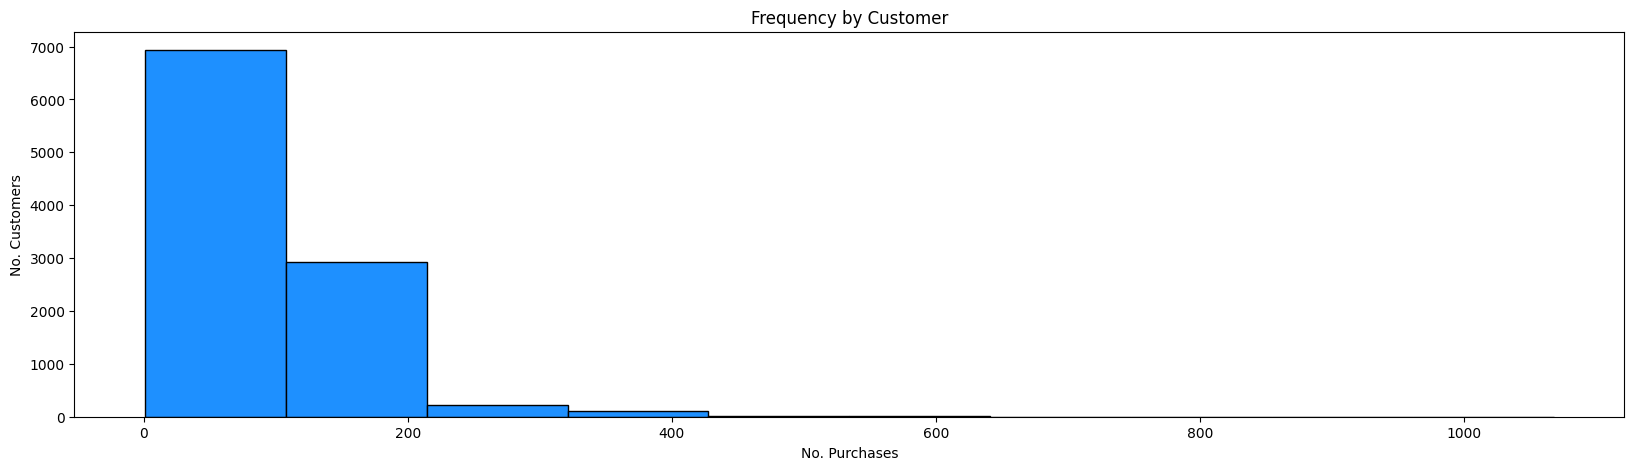

In [51]:
freq_fig = plt.figure(figsize=(20, 5))
plt.hist(df_customer["frequency"], color="dodgerblue", edgecolor="black")
plt.title("Frequency by Customer")
plt.ylabel("No. Customers")
plt.xlabel("No. Purchases")

plt.show()

In [53]:
df_customer["frequency"].value_counts(bins=[0, 5, 10, 100, 500, 1000, 5000])

(10.0, 100.0]       4379
(100.0, 500.0]      3296
(-0.001, 5.0]       1533
(5.0, 10.0]          985
(500.0, 1000.0]       14
(1000.0, 5000.0]       1
Name: frequency, dtype: int64

Most customers have a lower frequency, but a few big purchasers are also present in the data. Because this analysis is focused on the typical individual ticket buyer, let's remove these outliers:

In [54]:
df_customer = df_customer[df_customer["frequency"] <= 500]

Let's observe the standard statistics for the frequency metric now that we have removed the outliers:

In [55]:
df_customer["frequency"].describe()

count   10193.00
mean       74.41
std        76.53
min         1.00
25%        11.00
50%        43.00
75%       142.00
max       500.00
Name: frequency, dtype: float64

We could experiment with limiting frequency even further to < 5 games, but let's leave the limit at 10 games for now.

### Clustering Frequency

Let's apply the same k-means clustering with 3 clusters to assign a frequency cluster to each fan:

In [56]:
# build 3 clusters for frequency and add it to dataframe
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_customer[['frequency']])
df_customer['frequencycluster'] = kmeans.predict(df_customer[['frequency']])

df_customer = order_cluster('frequencycluster', 'frequency', df_customer, True)

In [57]:
df_customer.groupby('frequencycluster')["frequency"].describe()

,count,mean,std,min,25%,50%,75%,max
frequencycluster,,,,,,,,
0,6841.00,26.83,25.06,1.00,6.00,18.00,44.00,93.00
1,3121.00,160.76,26.78,94.00,139.00,167.00,171.00,239.00
2,231.00,316.86,60.00,240.00,261.00,317.00,346.50,500.00


Again, we see the lower value fans in cluster 0 that have only purchased for 1 event, compared to the higher value fans in cluster 2 who purchase on average 5.4 events.

### Revenue

Let’s add revenue to our dataset and cluster based on revenue:

In [58]:
df_revenue = df.groupby("dimcustomermasterid")["revenue"].sum().reset_index()

df_customer = pd.merge(df_customer, df_revenue, on="dimcustomermasterid")

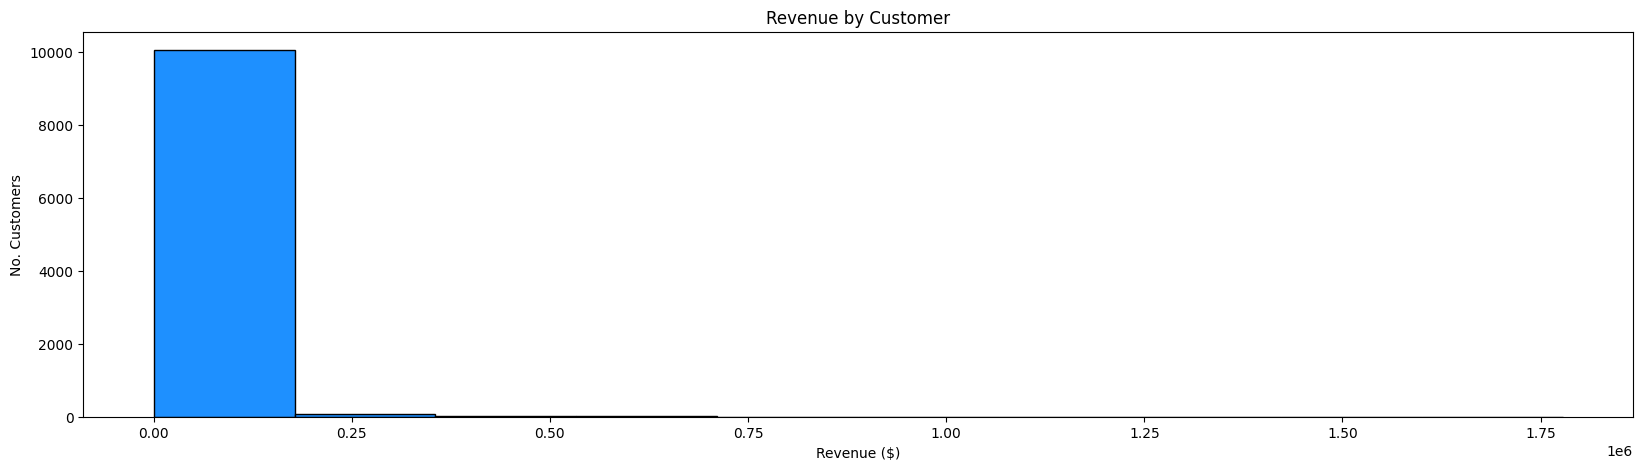

In [61]:
revenue_fig = plt.figure(figsize=(20, 5))
plt.hist(df_customer["revenue"], color="dodgerblue", edgecolor="black")
plt.title("Revenue by Customer")
plt.ylabel("No. Customers")
plt.xlabel("Revenue ($)")

plt.show()

In [64]:
df_customer["revenue"].value_counts(bins=[0, 50, 100, 500, 1000, 5000, 10000, 50000, 100000, 500000, 1000000, 5000000, 10000000])

(10000.0, 50000.0]         2951
(1000.0, 5000.0]           2746
(5000.0, 10000.0]          1550
(100.0, 500.0]              888
(500.0, 1000.0]             853
(50000.0, 100000.0]         712
(100000.0, 500000.0]        364
(50.0, 100.0]                77
(-0.001, 50.0]               32
(500000.0, 1000000.0]        16
(1000000.0, 5000000.0]        4
(5000000.0, 10000000.0]       0
Name: revenue, dtype: int64

Again, a few big spenders are present in the dataset. Let's remove the outlier customers who spend generate significantly more revenue than most:

In [65]:
df_customer = df_customer[df_customer["revenue"] <= 500000]

In [66]:
df_customer["revenue"].describe()

count    10173.00
mean     19652.71
std      39355.26
min          0.00
25%       1530.90
50%       6126.00
75%      19751.20
max     483644.00
Name: revenue, dtype: float64

These stats look reasonable, the min of $0 revenue may need some more investigation, but we can proceed with clustering the revenue for now.

### Clustering Revenue

Let's apply the same k-means clustering with 3 clusters to assign a revenue cluster to each fan:

In [67]:
# build 3 clusters for revenue and add it to dataframe
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_customer[['revenue']])
df_customer['revenuecluster'] = kmeans.predict(df_customer[['revenue']])

df_customer = order_cluster('revenuecluster', 'revenue', df_customer, True)

In [68]:
df_customer.groupby("revenuecluster")["revenue"].describe()

,count,mean,std,min,25%,50%,75%,max
revenuecluster,,,,,,,,
0,9024.00,9130.85,10723.37,0.00,1298.00,4744.20,13194.04,46305.00
1,1041.00,83451.60,32851.73,46364.80,58807.68,73541.80,98300.28,181764.00
2,108.00,283861.86,87513.96,186594.00,218052.15,249239.40,338372.00,483644.00


Once again, the clusters are ordered from low-high value with cluster 0 averaging ~$150 in revenue compared to ~$2000 in cluster 2.

### Engagement

Let's add a flag to show whether the fan has engaged with the team via purchasing a streaming subscription, or video game engagement provided by via the NBA dataset:

In [69]:

# merge the NBA dataset with our customer dataset
df_customer = pd.merge(df_customer, df2, on="dimcustomermasterid")

# create a flag based on the source of the record
df_customer["is_engaged"] = np.where(df_customer["entity_source"] == "PTB", 1, 0)
df_customer["is_engaged"].value_counts()


0    9700
1     473
Name: is_engaged, dtype: int64

Because this metric is binary (either 0 or 1) we don't need to cluster this metric.

### Overall Score

We have scores (cluster numbers) for recency, frequency & revenue, and our engagement score. Let’s create an overall score out of them:

In [71]:
# calculate overall score and use mean() to see details
df_customer["score"] = df_customer["recencycluster"]+df_customer["frequencycluster"]+df_customer["revenuecluster"]+df_customer["is_engaged"]+1

df_customer.groupby("score").agg({
    "recency": "mean",
    "frequency": "mean",
    "revenue": "mean",
    "is_engaged": "mean"
}).reset_index()

,score,recency,frequency,revenue,is_engaged
0,1,1373.35,29.10,4841.07,0.00
1,2,1055.42,20.07,3477.12,0.04
2,3,275.00,35.37,8645.24,0.03
3,4,225.35,149.50,20456.32,0.08
4,5,196.59,174.31,74539.53,0.11
5,6,155.91,256.46,152144.51,0.16
6,7,197.17,328.11,282020.28,0.09
7,8,157.00,254.00,189096.00,1.00


As we can see, the higher the score, the higher value a fan (more recent purchase, higher frequency, higher revenue, more engagement). Let's plot each score group to see the distribution of fans across the revenue spectrum:

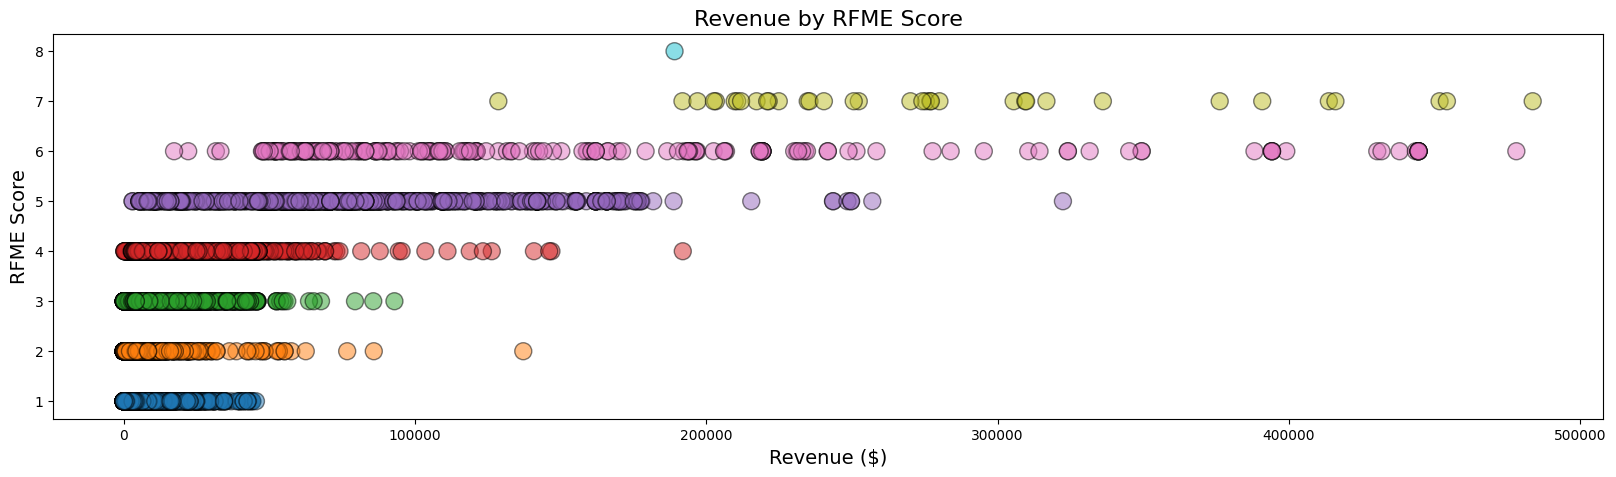

In [93]:
colors = {1:'tab:blue', 2:'tab:orange', 3:'tab:green', 4:'tab:red', 5:'tab:purple', 6:'tab:pink', 7:'tab:olive', 8:'tab:cyan'}

cluster_fig = plt.scatter(df_customer["revenue"], df_customer["score"], c=df_customer["score"].map(colors), edgecolors="black", s=150, alpha=.5)
plt.title("Revenue by RFME Score", fontsize=16)
plt.ylabel("RFME Score", fontsize=14)
plt.xlabel("Revenue ($)", fontsize=14)
plt.rcParams["figure.figsize"] = (20,5)

plt.show()

## Segmentation

Let's add a segment to each customer in our dataset:

In [94]:
# populate a segment column based on conditions
conditions  = [
    df_customer["country"].isin(["US","USA","Uni"]) & ~df_customer["stateprovince"].isin(["OR","WA","Orego","OREGO","Washi","WASHI"]), 
    df_customer["country"].isin(["US","USA","Uni"]) & df_customer["stateprovince"].isin(["OR","WA","Orego","OREGO","Washi","WASHI"]), 
    ~df_customer["country"].isin(["US","USA","Uni"]) & ~df_customer["stateprovince"].isin(["OR","WA","Orego","OREGO","Washi","WASHI"])
]

choices = ["Out-of-Market US", "In-Market US", "International"]
    
df_customer["segment"] = np.select(conditions, choices, default="In-Market US")

df_customer["segment"].value_counts()

In-Market US        9646
Out-of-Market US     496
International         31
Name: segment, dtype: int64

In [95]:
df_customer.head()

,dimcustomermasterid,country,stateprovince,recency,recencycluster,frequency,frequencycluster,revenue,revenuecluster,country_value,stateprovince_value,zippostal_value,entity_source,is_engaged,score,segment
0,702748196,USA,OR,554,2,253,2,70302.40,1,USA,OR,97123-4016,NaN,0,6,In-Market US
1,391535766,USA,OR,147,2,355,2,102289.60,1,USA,OR,97086-8037,NaN,0,6,In-Market US
2,784566531,USA,OR,164,2,271,2,159352.00,1,USA,OR,97203,NaN,0,6,In-Market US
3,471531233,USA,OR,164,2,246,2,110604.00,1,USA,OR,97204-3643,NaN,0,6,In-Market US
4,733074816,USA,OR,93,2,305,2,54137.64,1,USA,OR,97068,NaN,0,6,In-Market US


### Calculating TGR (Total Gross Revenue)

Let's use our RFME scores to calculate a Total Gross Revenue for each segment:

In [96]:
# calculate metrics used for tgr calc
df_tgr = df_customer.groupby(["segment", "score"]).agg(
    {
        "revenue": ["mean","sum"],
        "segment": ["count"]
    })

df_tgr.columns = ['revenue_avg', 'revenue_sum', 'fan_count']
df_tgr = df_tgr.reset_index()

In [97]:
df_tgr

,segment,score,revenue_avg,revenue_sum,fan_count
0,In-Market US,1,4972.44,8995144.29,1809
1,In-Market US,2,3577.30,6696698.67,1872
2,In-Market US,3,8801.21,23930502.55,2719
3,In-Market US,4,20548.54,42288904.46,2058
4,In-Market US,5,75196.82,72489737.66,964
5,In-Market US,6,153302.79,29127530.39,190
6,In-Market US,7,277671.47,9163158.48,33
7,In-Market US,8,189096.00,189096.00,1
8,International,1,983.36,10817.00,11
9,International,2,1982.31,15858.50,8


<Figure size 2000x500 with 0 Axes>

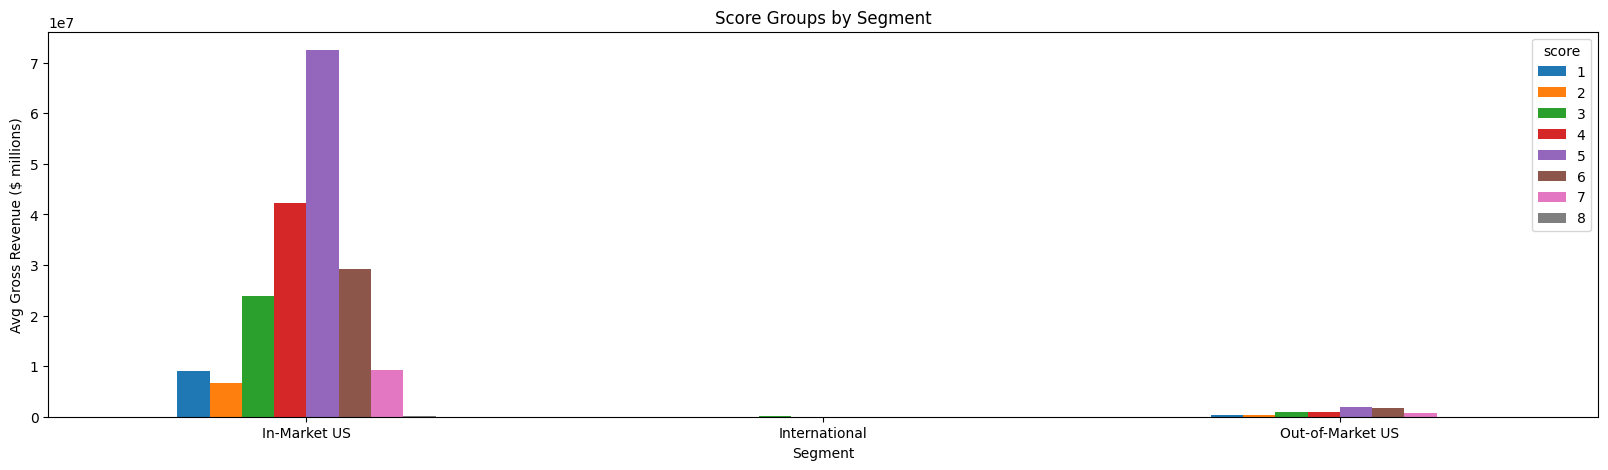

In [100]:
segment_fig = plt.figure(figsize=(20, 5))
df_tgr.pivot("segment", "score", "revenue_sum").plot(kind='bar')
plt.title("Score Groups by Segment")
plt.xlabel("Segment")
plt.xticks(rotation = 0)
plt.ylabel("Avg Gross Revenue ($ millions)")

plt.show()

We can also calculate the TGR for each overall segment:

In [101]:
tgr_aggs = df_customer.groupby("segment").agg({
    "revenue": "sum",
    "segment": "count"
})
tgr_aggs.columns = ["total_gross_revenue", "fan_count"]

tgr_aggs.head()

,total_gross_revenue,fan_count
segment,,
In-Market US,192880772.50,9646
International,107314.90,31
Out-of-Market US,6938896.89,496


In [103]:
in_market_tgr_per_fan = tgr_aggs.iloc[0]["total_gross_revenue"] / tgr_aggs.iloc[0]["fan_count"]
international_tgr_per_fan = tgr_aggs.iloc[1]["total_gross_revenue"] / tgr_aggs.iloc[1]["fan_count"]
out_market_tgr_per_fan = tgr_aggs.iloc[2]["total_gross_revenue"] / tgr_aggs.iloc[2]["fan_count"]

print(f"IN-MARKET US TGR PER FAN: {round(in_market_tgr_per_fan, 2)}")
print(f"OUT-OF-MARKET US TGR PER FAN: {round(out_market_tgr_per_fan, 2)}")
print(f"INTERNATIONAL TGR PER FAN: {round(international_tgr_per_fan, 2)}")

IN-MARKET US TGR PER FAN: 19995.93
OUT-OF-MARKET US TGR PER FAN: 13989.71
INTERNATIONAL TGR PER FAN: 3461.77


## Projections

Now that we have our segments and clusters, let's apply the same analysis to all fans in the NBA dataset and make some projections for **Potential Gross Revenue**.

We'll create a new df for the nba customer and select only fans from the nba data asset:

In [104]:
# select nba fans only from the df2 dataframe
df_nba_fans = df2[df2["entity_source"] == "NBA"]

# create a generic user dataframe to keep dimcustomermasterid and new segmentation scores
df_nba_customer = pd.DataFrame(df_nba_fans["dimcustomermasterid"].unique())
df_nba_customer.columns = ['dimcustomermasterid']

# merge nba customer df back with df2 to get country and state columns
df_nba_customer = pd.merge(df_nba_customer, df2[["dimcustomermasterid", "country_value", "stateprovince_value", "zippostal_value"]], on="dimcustomermasterid")
df_nba_customer.columns = ["dimcustomermasterid", "country", "stateprovince", "zippostal"]

df_nba_customer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 393277 entries, 0 to 393276
Data columns (total 4 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   dimcustomermasterid  393277 non-null  int64 
 1   country              295088 non-null  object
 2   stateprovince        15822 non-null   object
 3   zippostal            188291 non-null  object
dtypes: int64(1), object(3)
memory usage: 15.0+ MB


Now we can add a new segment column based on the customers location:

In [105]:
(df_nba_customer["zippostal"].str.startswith("97")==1).value_counts()

False    388012
True       5265
Name: zippostal, dtype: int64

In [106]:
# populate a segment column based on conditions
conditions  = [
    df_nba_customer["zippostal"].str.startswith("97")==1,
    df_nba_customer["zippostal"].str.startswith("98")==1, 
    df_nba_customer["country"].isin(["US","USA","Uni","United States"]),
    ~df_nba_customer["country"].isin(["US","USA","Uni", "United States"])
]

choices = ["In-Market US", "In-Market US", "Out-of-Market US", "International"]
    
df_nba_customer["segment"] = np.select(conditions, choices, default="In-Market US")

df_nba_customer["segment"].value_counts()

International       234385
Out-of-Market US    149933
In-Market US          8959
Name: segment, dtype: int64

In [108]:
international_gpr = round(df_nba_customer["segment"].value_counts().iloc[0] * international_tgr_per_fan, 2)
out_market_gpr = round(df_nba_customer["segment"].value_counts().iloc[0] * out_market_tgr_per_fan, 2)
in_market_gpr = round(df_nba_customer["segment"].value_counts().iloc[0] * in_market_tgr_per_fan, 2)

print(f"INTERNATIONAL GPR: ${round(international_gpr, 2):,}")
print(f"OUT-OF-MARKET US GPR: ${round(out_market_gpr, 2):,}")
print(f"IN-MARKET US GPR: ${round(in_market_gpr, 2):,}")

INTERNATIONAL GPR: $811,387,188.27
OUT-OF-MARKET US GPR: $3,278,978,523.31
IN-MARKET US GPR: $4,686,746,823.8


## TODO:
* calculate silhouette score for clusters
* change clustering to Pycaret
* break out clustering into own section?
* investiage event buyers > 100
* remove dollar tickets
* apply TGR to NBA segments
    - segment the NBA fans (in-market, out-of-market, international)
    - use the same distribution for clusters among segments to estimate fans/segment cluster
    - use the avg revenue per fan to aprx project gross revenue per segment/cluster

Questions:
1. Of package buyers, how much potential revenue is there ?
2. At what rate do indy buyers convert to package buyers ?
Let's add this (revenue * conv_rate) to the NBA Potential Gross Revenue
    